In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import os
import torch
import time

import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from model import BaselineModel

sns.set()
sns.color_palette("bright")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


In [15]:
seed = 42 
np.random.seed(seed)
torch.manual_seed(seed)

In [16]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

full_trainset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

batch_size = 100

num_train = len(full_trainset)
num_valid = int(0.1 * num_train)
num_train -= num_valid

trainset, validset = random_split(full_trainset, [num_train, num_valid])

# Create the DataLoader for training and validation sets
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=2)

# Download and load the test dataset
testset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Classes in CIFAR-10
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified


/cluster/home/jssaethe/.conda/envs/maptr/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [18]:
net = BaselineModel(num_channels=3)
net.to(device)

BaselineModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [20]:
num_epochs = 30
training_losses = []
validation_losses = []

for epoch in range(num_epochs): 
    start = time.time()
    net.train()
    training_loss = 0.0
    for (inputs, labels) in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        training_loss += loss.item()
    training_loss /= len(trainloader)
    training_losses.append(training_loss)

    # Validation
    net.eval()
    validation_loss = 0
    with torch.no_grad(): 
        for (inputs, labels) in validloader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
    
    validation_loss /= len(validloader)
    validation_losses.append(validation_loss)

    end = time.time()
    
    print(f"Epoch: {epoch+1}, training_loss: {training_loss}, validation_loss: {validation_loss}, time: {end-start:.2f}")    

Epoch: 1, training_loss: 2.301168359120687, validation_loss: 2.2965750741958617, time: 12.73
Epoch: 2, training_loss: 2.274173398547702, validation_loss: 2.2172620725631713, time: 16.38
Epoch: 3, training_loss: 2.0962623365720114, validation_loss: 2.029443571567535, time: 12.83
Epoch: 4, training_loss: 1.9701036741998461, validation_loss: 1.938299994468689, time: 14.22
Epoch: 5, training_loss: 1.8927873918745253, validation_loss: 1.8690851306915284, time: 17.36
Epoch: 6, training_loss: 1.813412476380666, validation_loss: 1.7828548598289489, time: 13.64
Epoch: 7, training_loss: 1.7160393116209243, validation_loss: 1.6683937096595765, time: 14.64
Epoch: 8, training_loss: 1.6221763682365418, validation_loss: 1.6127776384353638, time: 15.43
Epoch: 9, training_loss: 1.5660986206266616, validation_loss: 1.5669915461540223, time: 15.32
Epoch: 10, training_loss: 1.5235660277472602, validation_loss: 1.5300349283218384, time: 13.47
Epoch: 11, training_loss: 1.4884485297732883, validation_loss: 1

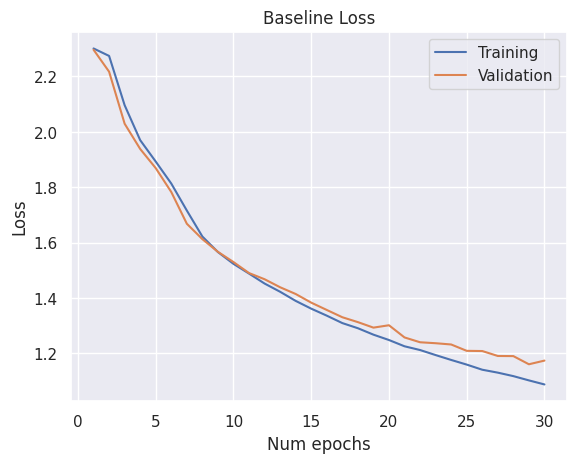

In [21]:
x = np.linspace(1, len(training_losses), len(training_losses))
plt.plot(x, training_losses, label="Training")
plt.plot(x, validation_losses, label="Validation")
plt.xlabel("Num epochs")
plt.ylabel("Loss")
plt.title("Baseline Loss")
plt.legend()

plt.show()

In [23]:
correct = 0
total = 0

with torch.no_grad():
    for (images, labels) in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

/cluster/home/jssaethe/.conda/envs/maptr/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy of the network on the 10000 test images: 58 %
